# XGBoost Route-Level Delay Forecasting

XGBoost model, using the full 63-feature tabular set including lag features, rolling stats, route aggregations, and weather data. Hyperparameters were tuned with Optuna (50 trials, validation MAE as the objective).

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import TABULAR_FEATURES, WEATHER_FEATURES

## Load Data

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

print(f'Total samples: {len(df):,}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Routes: {df["route"].nunique()}')

Total samples: 118,650
Date range: 2019-01-01 00:00:00 to 2025-06-30 00:00:00
Routes: 50


## Feature Selection

Using the full 63-feature `TABULAR_FEATURES` set from `src/config.py`.

**Optuna-tuned hyperparameters** (50 trials, validation MAE objective):
- n_estimators=200, max_depth=10, learning_rate=0.029
- subsample=0.63, colsample_bytree=0.92, min_child_weight=4
- reg_alpha=0.029, reg_lambda=9.46

In [3]:
# filter to available features in dataset
available_features = [c for c in TABULAR_FEATURES if c in df.columns]
target_col = 'avg_arr_delay'

print(f'Using {len(available_features)} features for XGBoost (full tabular set)')
print(f'Target: {target_col}')

Using 63 features for XGBoost (full tabular set)
Target: avg_arr_delay


## Train/Test Split

In [4]:
# create train/val/test splits
train_df = df[df['date'] < TRAIN_END].dropna(subset=available_features + [target_col])
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].dropna(subset=available_features + [target_col])
test_df = df[df['date'] >= TEST_START].dropna(subset=available_features + [target_col])

X_train = train_df[available_features].values
y_train = train_df[target_col].values

X_val = val_df[available_features].values
y_val = val_df[target_col].values

X_test = test_df[available_features].values
y_test = test_df[target_col].values

print(f'Training samples: {len(X_train):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'Test samples: {len(X_test):,}')
print(f'Train period: {train_df["date"].min()} to {train_df["date"].max()}')
print(f'Val period: {val_df["date"].min()} to {val_df["date"].max()}')
print(f'Test period: {test_df["date"].min()} to {test_df["date"].max()}')

Training samples: 91,300
Validation samples: 9,100
Test samples: 18,250
Train period: 2019-01-01 00:00:00 to 2023-12-31 00:00:00
Val period: 2024-01-01 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-01 00:00:00 to 2025-06-30 00:00:00


## Load Trained Model

Pre-trained with `src/training/train/train_xgboost.py`.

In [5]:
# load pre-trained XGBoost model
model = joblib.load('../trained_models/xgboost_delay.pkl')
print(f'Loaded XGBoost model (best iteration: {model.best_iteration})')

Loaded XGBoost model (best iteration: 189)


## Evaluate on Test Set

In [6]:
# evaluate model on test set
y_pred = model.predict(test_df[available_features])

metrics = calculate_delay_metrics(y_test, y_pred)

print('\nXGBoost Test Set Metrics (Route-Level Delay Forecasting):')
print(f'  MAE:              {metrics["mae"]:.2f} min')
print(f'  RMSE:             {metrics["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics["within_15"]:.1f}%')
print(f'  Delay Detection:  {metrics["threshold_acc"]:.1f}%')
print(f'  R\u00b2:               {metrics["r2"]:.3f}')


XGBoost Test Set Metrics (Route-Level Delay Forecasting):
  MAE:              11.21 min
  RMSE:             19.22 min
  Within 15min:     78.7%
  Delay Detection:  83.9%
  R²:               0.325


## Baseline Comparison

In [7]:
# compare XGBoost against naive and rolling baselines
naive_preds = test_df.groupby('route').apply(
    lambda x: x[target_col].shift(1), include_groups=False
).droplevel(0).dropna()

naive_targets = test_df.loc[naive_preds.index, target_col]
naive_metrics = calculate_delay_metrics(naive_targets.values, naive_preds.values)

rolling_preds = test_df.groupby('route').apply(
    lambda x: x[target_col].shift(1).rolling(7, min_periods=1).mean(), include_groups=False
).droplevel(0).dropna()

rolling_targets = test_df.loc[rolling_preds.index, target_col]
rolling_metrics = calculate_delay_metrics(rolling_targets.values, rolling_preds.values)

comparison = pd.DataFrame([
    {'Model': 'Naive (last value)', 'MAE (min)': naive_metrics['mae'], 'RMSE (min)': naive_metrics['rmse'], 'Within 15min (%)': naive_metrics['within_15'], 'R\u00b2': naive_metrics['r2']},
    {'Model': 'Rolling Mean (7-day)', 'MAE (min)': rolling_metrics['mae'], 'RMSE (min)': rolling_metrics['rmse'], 'Within 15min (%)': rolling_metrics['within_15'], 'R\u00b2': rolling_metrics['r2']},
    {'Model': f'XGBoost ({len(available_features)} features)', 'MAE (min)': metrics['mae'], 'RMSE (min)': metrics['rmse'], 'Within 15min (%)': metrics['within_15'], 'R\u00b2': metrics['r2']},
]).set_index('Model').round(2)

xgb_vs_naive = (naive_metrics['mae'] - metrics['mae']) / naive_metrics['mae'] * 100

print('Model Comparison on Test Set (2024-07-01 to 2025-06-30):')
print(f'XGBoost improvement over naive: {xgb_vs_naive:.1f}%')
comparison

Model Comparison on Test Set (2024-07-01 to 2025-06-30):
XGBoost improvement over naive: 26.2%


,MAE (min),RMSE (min),Within 15min (%),R²
Model,,,,
Naive (last value),15.19,25.60,67.71,-0.19
Rolling Mean (7-day),13.93,22.63,69.49,0.07
XGBoost (63 features),11.21,19.22,78.67,0.33


## Feature Importance

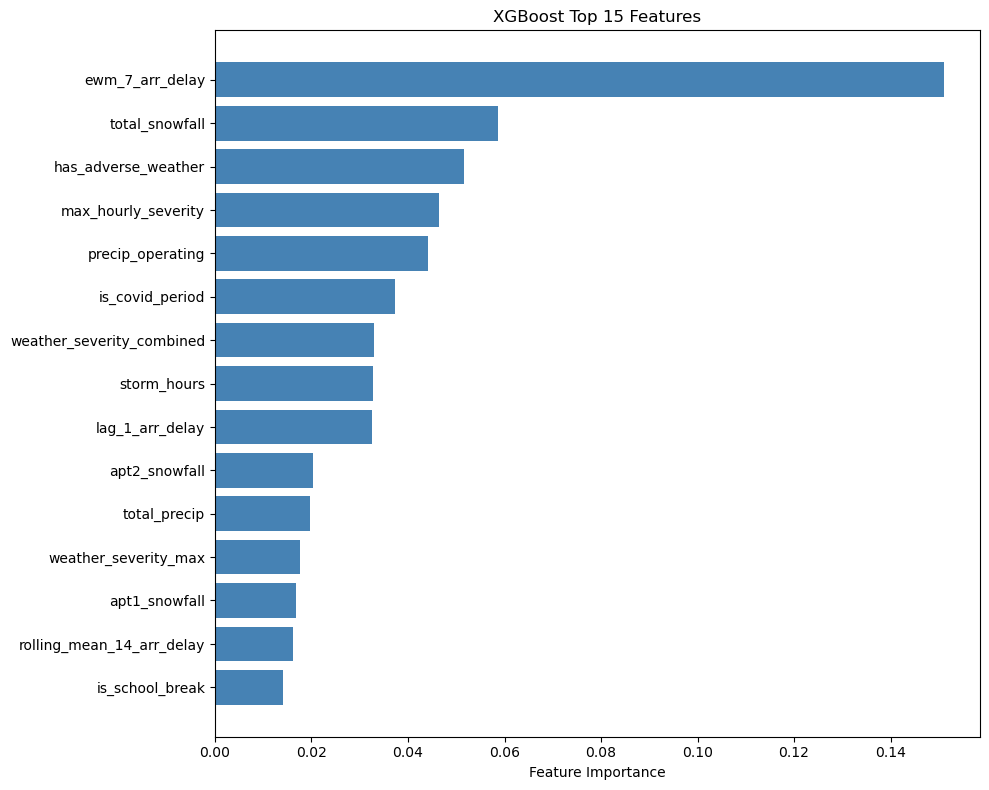

In [8]:
# plot feature importance
importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
top_features = importance_df.tail(15)
ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Top 15 Features')
plt.tight_layout()
plt.show()

## Forecast vs Actual Plot

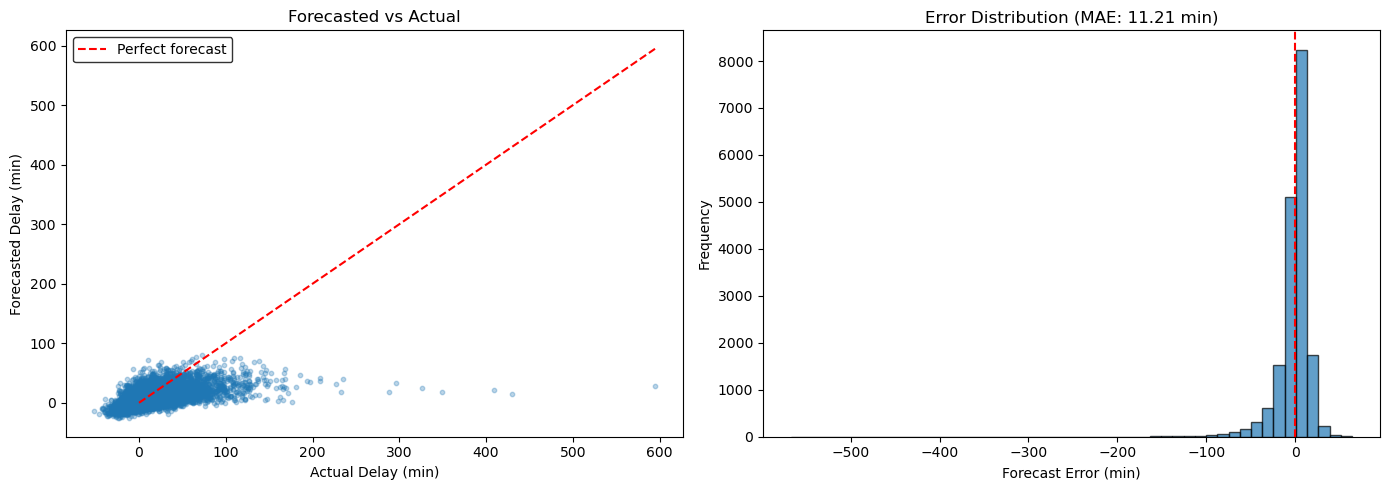

In [9]:
# plot forecasts vs actuals and error distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_pred, alpha=0.3, s=10)
max_val = max(y_test.max(), y_pred.max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect forecast')
ax1.set_xlabel('Actual Delay (min)')
ax1.set_ylabel('Forecasted Delay (min)')
ax1.set_title('Forecasted vs Actual')
ax1.legend(frameon=True, edgecolor='black')

errors = y_pred - y_test
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_xlabel('Forecast Error (min)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Error Distribution (MAE: {metrics["mae"]:.2f} min)')

plt.tight_layout()
plt.show()

## Ablation: Weather Feature Impact

XGBoost clearly outperforms baselines. To see how much the weather data actually helps, I trained an identical model without the 28 weather features (dropping from 63 to 35 features).

In [10]:
# prepare non-weather feature set for ablation
non_weather_features = [f for f in available_features if f not in WEATHER_FEATURES]

print(f'Full model features: {len(available_features)}')
print(f'Weather features removed: {len([f for f in WEATHER_FEATURES if f in available_features])}')
print(f'Ablation model features: {len(non_weather_features)}')

Full model features: 63
Weather features removed: 28
Ablation model features: 35


In [11]:
# train an identical model without weather features for comparison
X_train_no_weather = train_df[non_weather_features].values
X_val_no_weather = val_df[non_weather_features].values
X_test_no_weather = test_df[non_weather_features].values

# same Optuna-tuned hyperparameters as the production model so only the features differ
ablation_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.029,
    'subsample': 0.63,
    'colsample_bytree': 0.92,
    'min_child_weight': 4,
    'reg_alpha': 0.029,
    'reg_lambda': 9.46,
    'early_stopping_rounds': 50,
    'random_state': 42,
    'n_jobs': -1
}

model_no_weather = xgb.XGBRegressor(**ablation_params)

print('Training XGBoost without weather features...')
model_no_weather.fit(
    X_train_no_weather, y_train,
    eval_set=[(X_val_no_weather, y_val)],
    verbose=20
)
print(f'Training complete. Best iteration: {model_no_weather.best_iteration}')

Training XGBoost without weather features...
[0]	validation_0-rmse:24.36860
[20]	validation_0-rmse:22.85964
[40]	validation_0-rmse:22.29009
[60]	validation_0-rmse:22.07512
[80]	validation_0-rmse:21.99019
[100]	validation_0-rmse:21.95295
[120]	validation_0-rmse:21.95061
[140]	validation_0-rmse:21.95784
[160]	validation_0-rmse:21.97894
[162]	validation_0-rmse:21.97949
Training complete. Best iteration: 112


In [12]:
# evaluate model without weather features
y_pred_no_weather = model_no_weather.predict(test_df[non_weather_features])
metrics_no_weather = calculate_delay_metrics(y_test, y_pred_no_weather)

print('\nAblation Results (Without Weather Features):')
print(f'  MAE:              {metrics_no_weather["mae"]:.2f} min')
print(f'  RMSE:             {metrics_no_weather["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics_no_weather["within_15"]:.1f}%')
print(f'  R²:               {metrics_no_weather["r2"]:.3f}')


Ablation Results (Without Weather Features):
  MAE:              12.50 min
  RMSE:             20.83 min
  Within 15min:     74.0%
  R²:               0.208


In [13]:
# how much did weather features actually help?
mae_change = (metrics_no_weather['mae'] - metrics['mae']) / metrics_no_weather['mae'] * 100
hit_rate_change = metrics['within_15'] - metrics_no_weather['within_15']

ablation = pd.DataFrame([
    {'Model': f'Without Weather ({len(non_weather_features)} features)', 'MAE (min)': metrics_no_weather['mae'], 'RMSE (min)': metrics_no_weather['rmse'], 'Within 15min (%)': metrics_no_weather['within_15'], 'R²': metrics_no_weather['r2']},
    {'Model': f'With Weather ({len(available_features)} features)', 'MAE (min)': metrics['mae'], 'RMSE (min)': metrics['rmse'], 'Within 15min (%)': metrics['within_15'], 'R²': metrics['r2']},
]).set_index('Model').round(3)

print('Weather Feature Ablation Study')
print(f'Weather features reduce MAE by {mae_change:.1f}% and improve hit rate by {hit_rate_change:.1f} percentage points')
ablation

Weather Feature Ablation Study
Weather features reduce MAE by 10.3% and improve hit rate by 4.6 percentage points


,MAE (min),RMSE (min),Within 15min (%),R²
Model,,,,
Without Weather (35 features),12.497,20.825,74.044,0.208
With Weather (63 features),11.209,19.221,78.674,0.325


## Summary

XGBoost with the full 63-feature set (Optuna-tuned over 50 trials) is a solid improvement over the baselines. The weather ablation was interesting: removing the 28 weather features bumps MAE up noticeably, so collecting weather data per airport paid off.

The model trains on 50 routes but the dashboard will display predictions for the top 20 by traffic volume. Next I'll check LightGBM performance on the same features to see if a different boosting algorithm changes anything.

**Next:** [05_lightgbm_delay.ipynb](05_lightgbm_delay.ipynb)